## Model Isinga - symulacja Monte Carlo
autor: Bartosz Kreft (418184)

Model Isinga, znany również jako model magnetyczny Isinga, to prosty model matematyczny stosowany w fizyce statystycznej do opisania układów o spinie, takich jak magnetyki. Model ten został opracowany przez niemieckiego fizyka Ernsta Isinga w 1925 roku i od tego czasu znalazł szerokie zastosowanie w różnych dziedzinach nauki.

W modelu Isinga zakłada się, że spiny oddziałują jedynie ze swoimi najbliższymi sąsiadami. Wpływ tych oddziaływań jest opisywany przez parametr zwany siłą oddziaływania lub stałą sprzężenia. 

Rozpatrujemy spiny rozłożone na sieci kwadratowej o torusowych własnościach brzegowych. Spiny mogą przyjmować jedno z dwóch możliwych stanów: 
* "góra" (+1, $\uparrow$)
* "dół" (-1, $\downarrow$).

Spinami można interpretować na przykład atomowe magnesy, w których kierunek magnetyzacji może być skierowany w górę lub w dół. W zależności od kontekstu, config mogą również reprezentować inne obiekty, takie jak cząsteczki w ciele stałym. Pełny hamniltonian układu ma postać:

$$\begin{equation*}
 \mathcal{H} = -J\sum_{\langle i,j \rangle} S_i S_j - H\sum_{i=1}^{N} S_i \;,
\end{equation*}$$
gdzie $S_i, S_j$ to wartości sąsiednich spinów w sieci, $N$ to wymiar sieci, parametr $H$ jest związany gdy w modelu występuje zewnętrzna. Natomiast parametr $J$ odpowiada za siłę oddziaływań pomiędzy sąsiednimi spinami:
* $J>0$ - ferromagnetyczne (ustawia spiny w jednym kierunku, przeciwnym do zewnętrznego pola),
* $J<0$ - antyferromagnetyczne,
* $J=0$ - para spinów nie oddziałuje ze sobą.

Podstawowym celem modelu Isinga jest opisanie termodynamicznych właściwości układu spinów, takich jak temperatura krytyczna, magnetyzacja czy energia swobodna. Istnieją różne metody matematyczne i numeryczne, takie jak metoda Monte Carlo, które pozwalają na analizę i symulację modelu Isinga w celu zrozumienia zachowania układu w różnych warunkach.

Model Isinga ma zastosowanie w wielu dziedzinach nauki, w tym w fizyce ciała stałego, fizyce statystycznej, teorii pola, naukach przyrodniczych i informatyce. Jego prostota i jednocześnie zdolność do opisywania złożonych zachowań czynią go popularnym narzędziem badawczym w różnych dziedzinach nauki.

### Założenia symulacji
W przedstawionej symulacji zakładamy, że $H=0$, czyli układ nieoddziaływuje z zewnętrznym polem magnetycznym oraz spiny przy krawędziach oddziaływują ze spinami z drugiej krawędzi, tak aby interakcje pomiędzy spianmi były zgodne z geometrią torusa. W jednostkach $k_B=1$.


### NAPISAĆ RAPORT MAKS 1str A4 link do kodu(drive)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scienceplots
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

plt.style.use(['science','notebook', 'grid'])

import warnings
warnings.filterwarnings('ignore')

In [5]:
class Ising():
    ''' Symulacja modelu Isinga '''    
    
    def __init__(self, N=10, temp=0.4, J=1, NIter=1000):
        self.N = N              # wielkość siatki
        self.temp = temp        # temperatura w kelvinach
        self.J = J              # stała sprzężnia
        self.NIter = NIter      # liczba kroków w metodzie Monte Carlo
        # self.CriticalTemp = 2*self.J
        self.config = 2*np.random.randint(2, size=(self.N, self.N))-1 
        self.init_config = self.config.copy()

        self.M, self.E = [], []
        
    def MetropolisMove(self, config, N, beta):
        ''' Krok metody Monte Carlo przy pomocy 
        algorytmu Metropolis '''
        for i in range(N):
            for j in range(N):            
                # wybór lsowego spinu z sieci
                a = np.random.randint(0,N)
                b = np.random.randint(0,N)
                spin_i =  config[a, b] # początkiowy spin
       
                # Energia
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                dE = 2*nb*spin_i
                
                # if (dE < 0) or (np.rand() < np.exp(-dE*beta)):	
                #     spin_i *= -1 # obracanie spinu

                if (dE < 0):	
                    spin_i *= -1 # obracanie spinu
                elif np.random.random() < np.exp(-dE*beta):
                    spin_i *= -1 # obracanie spinu

                config[a, b] = spin_i
        return config
    
    def GetAverageMagnetization(self):
        return np.sum(self.config)/len(self.config)**2

    def CalcEnergy(self):
        '''Energia układu w danym stanie, spiny jedynie oddziałyywują w pierwszej strefie kordynacyjnej'''
        N = len(self.config)
        energy = 0
        lattice_energy = np.zeros(self.config.shape)
        for i in range(len(self.config)):
            for j in range(len(self.config)):
                S = self.config[i,j]
                nb = self.config[(i+1)%N, j] + self.config[i,(j+1)%N] + self.config[(i-1)%N, j] + self.config[i,(j-1)%N]
                energy += -self.J*nb*S
                lattice_energy[i,j] = -self.J*nb*S
        return energy/4., lattice_energy 

    def CalcMagnetization(self):
        mag = np.sum(self.config)
        return mag
    
    def IsConfigStable(self, config):
        return np.abs(self.GetEnergy(config)[0]) == np.size(config)

    def SimulateAnimation(self):   
        ''' Faktyczna symulacja'''
        fig, ax = plt.subplots(figsize=(5, 5), dpi=90)
        self.config = self.init_config
        ims = []
        for i in range(self.NIter):
            self.MetropolisMove(self.config, self.N, 1.0/self.temp)
            
            ax.set_xticks([])
            ax.set_yticks([])
            im = ax.imshow(self.config, interpolation='nearest', cmap=cm.gray, animated=True)
            ttl = plt.text(0.5, 1.01, "SYMULACJA MODELU ISINGA 2D \n Krok: "+str(i)+"  N="+str(self.N)+"  T="+str(self.temp)+"K", 
                        horizontalalignment='center', 
                        verticalalignment='bottom', 
                        transform=ax.transAxes,
                        fontsize='xx-large')

            ims.append([im, ttl])

        animation.ArtistAnimation(fig, ims, 
                                  interval=120, 
                                  blit=True,
                                  repeat_delay=1000).save("Sims\Ising"+str(self.N)+".gif")
        plt.close()

    def GetNameOfSimulation(self):
        return "Ising"+str(self.N)+".gif"

In [6]:
rm = Ising(N=256, NIter=int(1e3))

In [7]:
# rm.SimulateAnimation()

In [47]:
from IPython.display import Image, clear_output
clear_output(wait=True)
Image(url='./Sims/'+rm.GetNameOfSimulation())  

### Wielkości fizyczne związane z Modelem Isinga

In [12]:
@njit
def Ising2dSimulation(config, T=1, J=1, B=0, n_steps=200000, out_freq=10):
    N = len(config)

    M_t = np.sum(config)
    E_t = B*M_t
    for i in range(N):
        for j in range(N): 
            E_t += -J*(config[(i+1)%N, j] + config[(i-1)%N, j] + config[i,(j+1)%N] + config[i,(j-1)%N])

    S, E, M = [], [], []
    for step in range(n_steps):
        i, j = np.random.randint(N), np.random.randint(N)

        z  = config[(i+1)%N, j] + config[(i-1)%N, j] + config[i, (j+1)%N] + config[i, (j-1)%N] 
        dE = 2*config[i,j]*(J*z + B)

        # Metropolis condition
        if np.exp(-dE/T) > np.random.rand():
            config[i,j] *= -1 
            E_t += dE
            M_t += 2*config[i,j]

        # Save Thermo data
        if step % out_freq == 0:
            M.append(M_t/N**2)
            E.append(E_t/N**2)
            S.append(config.copy())

    return S, E, M
J=1
N=16
nt = 200
Ts = np.linspace(1, 5, nt) 
Es, Ms, Cs, Xs = [], [], [], []  
n_steps=100000
out_freq=10
config =  2*np.random.randint(2, size=(N, N))-1

for T in Ts:
    S, E, M = Ising2dSimulation(config, T=T, J=1, n_steps=2*n_steps)
    M = M[n_steps//out_freq:]

    Ms.append(np.mean(M))
    Xs.append(np.var(M)/T)

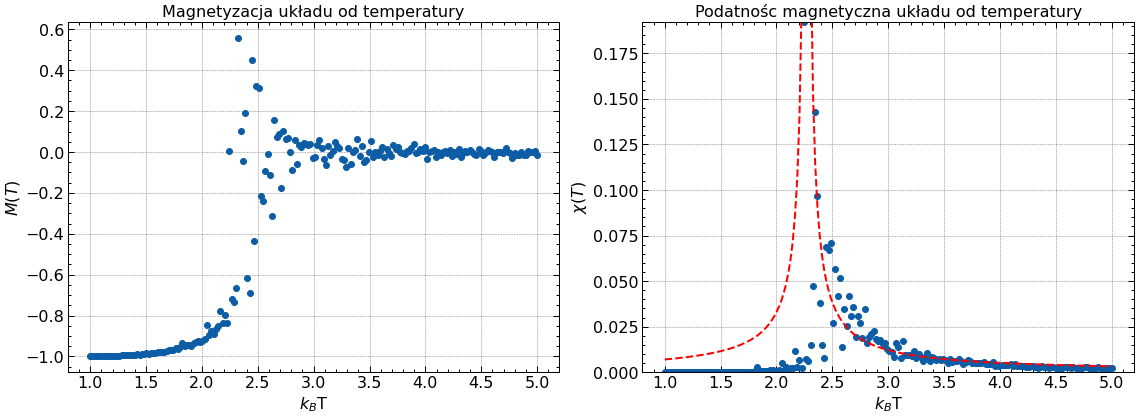

In [48]:
Tc = 2.269185*J
fig, ax  = plt.subplots(ncols=2, nrows=1, figsize=(16,6))

ax[0].set_title("Magnetyzacja układu od temperatury")
# ax[0].plot(Ts, [(1-T/Tc)**(1/T)/N**2 for T in Ts], '--', c='r')
ax[0].scatter(Ts, Ms)
ax[0].set(ylabel='$M(T)$',xlabel='$k_B$T')
ax[0]

ax[1].set_ylim([0, max(Xs)])
ax[1].set_title("Podatnośc magnetyczna układu od temperatury")
ax[1].plot(Ts, [abs(1-T/Tc)**(-1)/N**2 for T in Ts], '--', c='r')
ax[1].scatter(Ts, Xs)
ax[1].set(ylabel='$\chi (T)$', xlabel='$k_B$T')

fig.tight_layout()

fig.savefig("plots/wykresy.png", format='png')